In [1]:
import os
import numpy as np
import matplotlib.pylab as plt

In [2]:
%matplotlib inline

In [3]:
IMG = 'D0CW-51310_108.jpg'
PATH = './images/'

In [4]:
data = plt.imread(os.path.join(PATH, IMG))

In [5]:
data.shape

(964, 1288)

In [6]:
ds_h = 2
ds_w = 2

In [7]:
'''
data is a fairly high resolution image, which will be somewhat slow
to work with, even on a GPU. We might be able to get away with throwing 
away every other pixel along height and width (aka downsampling).
'''
ds_data = data[::ds_h, ::ds_w] 

In [8]:
ds_data.shape

(482, 644)

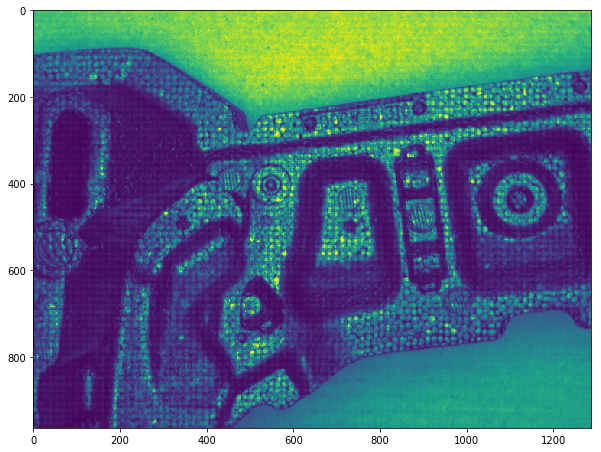

In [9]:
plt.figure(figsize=(10,8))
plt.imshow(data)

In [10]:
'''
Normally you import all required modules you want to use 
at the beginning of a Python file, but this is also valid.
I'm attempting to import modules close to where they are
actually used so you know where they came from.
'''
from skimage.feature import canny

In [15]:
edges = canny(ds_data, sigma=2) # experiment with different sigma values here and see what happens

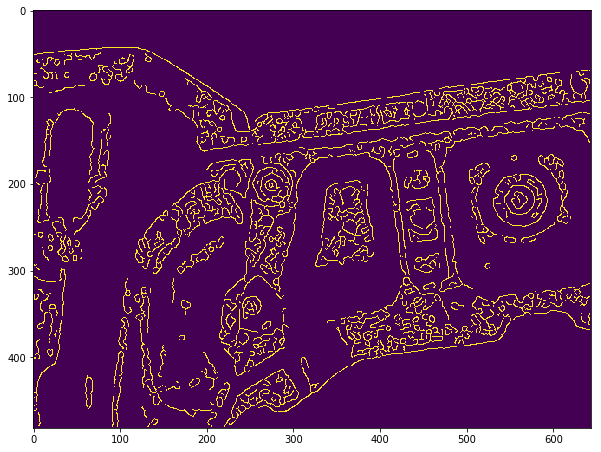

In [16]:
plt.figure(figsize=(10,8))
plt.imshow(edges)

In [111]:
from skimage import data, color
from skimage.transform import hough_circle
from skimage.feature import peak_local_max

In [112]:
# Detect small radii
hough_radii_sm = np.arange(24, 27, 1)
hough_res = hough_circle(edges, hough_radii_sm)

In [113]:
# create a bunch of empty lists
s_centers = []
s_accums = []
s_radii = []
l_centers = []
l_accums = []
l_radii = []

In [114]:
for radius, h in zip(hough_radii_sm, hough_res):
    num_peaks = 1
    peaks = peak_local_max(h, num_peaks=num_peaks)
    s_centers.extend(peaks)
    s_accums.extend(h[peaks[:, 0], peaks[:, 1]])
    s_radii.extend([radius] * num_peaks)

In [115]:
from skimage.draw import circle_perimeter, line

In [116]:
top_n_circ=1
image = color.gray2rgb(ds_data)
for idx in np.argsort(s_accums)[::-1][:top_n_circ]:
    x1, y1 = s_centers[idx]
    radius = s_radii[idx]
    cx, cy = circle_perimeter(y1, x1, radius)
    try:
        image[cy, cx] = (220, 20, 20)
        image[cy + 1, cx + 1] = (220, 20, 20)
        image[cy - 1, cx - 1] = (220, 20, 20)
    except:
        pass
print('Found small circle at coordinates (x=%d, y=%d)' % ((y1,x1)))

Found small circle at coordinates (x=274, y=201)


In [117]:
# Detect large radii
hough_radii_lrg = np.arange(45, 50, 1)
hough_res = hough_circle(edges, hough_radii_lrg)

for radius, h in zip(hough_radii_lrg, hough_res):
    num_peaks = 1
    peaks = peak_local_max(h, num_peaks=num_peaks)
    l_centers.extend(peaks)
    l_accums.extend(h[peaks[:, 0], peaks[:, 1]])
    l_radii.extend([radius] * num_peaks)            

In [118]:
image = color.gray2rgb(image)

for idx in np.argsort(l_accums)[::-1][:top_n_circ]:
    x2, y2 = l_centers[idx]
    radius = l_radii[idx]
    cx, cy = circle_perimeter(y2, x2, radius)
    rr, cc = line(x1, y1, x2, y2)
    try:
        image[cy, cx] = (20, 220, 20)
        image[cy + 1, cx + 1] = (20, 220, 20)
        image[cy - 1, cx - 1] = (20, 220, 20)
        image[rr, cc]=(20,20,220)
        image[rr + 1, cc + 1]=(20,20,220)
        image[rr - 1, cc - 1]=(20,20,220)
    except:
        pass

print('Found large circle at coordinates (x=%d, y=%d)' % ((y2,x2)))

Found large circle at coordinates (x=560, y=219)


In [119]:
euclidean_distance = np.sqrt((x2-x1)**2 + (y2-y1)**2)

In [120]:
from scipy import ndimage
DFL_SLOPE = 0.25
L2_LOWER_LIMIT = 280
L2_UPPER_LIMIT = 300

Crop and display the region of interest

Euclidean distance=286, slope=0.063


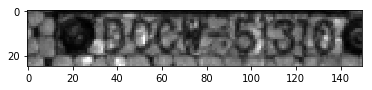

In [121]:
below_lower_bound = euclidean_distance < L2_LOWER_LIMIT
exceeds_upper_bound = euclidean_distance > L2_UPPER_LIMIT

if below_lower_bound or exceeds_upper_bound:
    print(Fore.RED + 'Euclidean distnance fail =' + str(int(euclidean_distance)))
    print(Style.RESET_ALL)
else:
    m = float(x2 - x1) / (y2 - y1)
    print('Euclidean distance=%d, slope=%.3f' % (euclidean_distance, m))

    # If y-coord of big circle is below y-coord small circle
    if y2 - y1 > 0:
        orig = ndimage.rotate(ds_data, angle=(m - DFL_SLOPE) * 45, reshape=False)
        
        '''
        these are magic numbers relating to 
        size in pixels of the rectangle containing the 
        actual serial number 
        '''
        auto_crop = orig[x1 - 80:x1 - 55, y1 + 40:y1 + 190] 
        fig = plt.figure()
        ax = fig.gca()
        ax.imshow(auto_crop, cmap=plt.cm.gray)    
        plt.show()

### Display the original downsampled image with features annotated

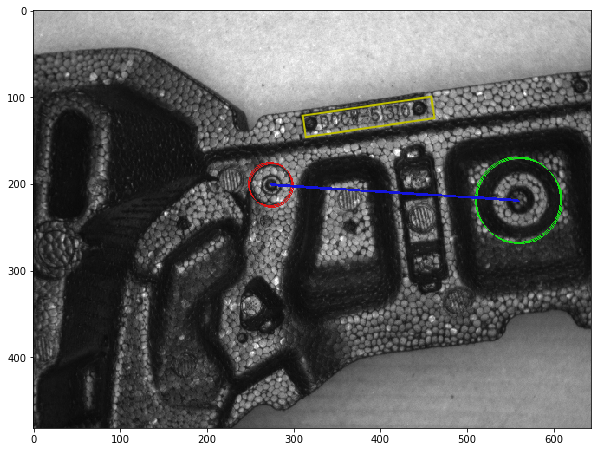

In [122]:
fig2 = plt.figure(figsize=(10,8))
ax2 = fig2.gca()
'''
Create a yellow bounding box around the region of 
interest. 

Aside: Use a back slash '\' to break up long lines,
PEP8 Python Standard recommends no more than 80 chars.
This makes it easier to track changes in revision 
control (e.g Git)
'''
rect2 = plt.Rectangle((y1 + 40, x1 - 55), 190 - 40, -80 + 55, \
                      angle=(m - DFL_SLOPE) * 45, edgecolor='y', \
                      facecolor='none', linewidth=2)
ax2.add_patch(rect2)
ax2.imshow(image, cmap=plt.cm.gray)